In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-english-parallel-corpus/hindi_english_parallel.csv
/kaggle/input/english-to-hindi-parallel-dataset/newdata.csv


In [26]:
# !rm -rf /kaggle/working/*

In [4]:
# installing all dependencies
! pip install sacrebleu evaluate sacremoses
! pip install -U bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 424.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.

In [5]:
import torch
import pandas as pd
import numpy as np
import regex
import unicodedata
import os

import evaluate
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    MarianMTModel,
    MarianTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    BitsAndBytesConfig,
    pipeline,
    EarlyStoppingCallback
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel

os.environ["WANDB_DISABLED"]="true"
torch.__version__

2025-08-13 06:00:26.409475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755064826.602691      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755064826.660934      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.6.0+cu124'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
df = pd.read_csv("/kaggle/input/english-to-hindi-parallel-dataset/newdata.csv")
df.dropna(ignore_index=True, inplace=True) # droping empty datapoints
df.drop(columns=['Unnamed: 0'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177604 entries, 0 to 177603
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   english_sentence  177604 non-null  object
 1   hindi_sentence    177604 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [8]:
def is_hindi_corrupted(text):
    # Flags if any non-Devanagari, non-allowed punctuation/space chars are present
    if regex.search(r'[^\u0900-\u097F\s,.?!-]', text):
        return True
    return False

# Apply the function to create a mask
df['Corrupted'] = df['hindi_sentence'].apply(is_hindi_corrupted)

# Filter out corrupted rows, then drop the mask column
df = df[~df['Corrupted']].drop(columns=['Corrupted'])

# Reset index without keeping old index as a column
df.reset_index(drop=True, inplace=True)

def clean_text(text, language="english"):
    # Normalize unicode characters
    text = unicodedata.normalize('NFKC', text)
    # Convert to lowercase if English
    if language == "english":
        text = text.lower()
    # Remove extra spaces
    text = regex.sub(r'\s+', ' ', text).strip()
    return text

# Compute word counts on original sentences (move after cleaning if preferred)
df['english_words'] = df['english_sentence'].apply(lambda x: len(x.split()))
df['hindi_words'] = df['hindi_sentence'].apply(lambda x: len(x.split()))

# Apply cleaning and create new columns
df['english_sentence'] = df['english_sentence'].apply(lambda x: clean_text(x))
df['hindi_sentence'] = df['hindi_sentence'].apply(lambda x: clean_text(x, language="hindi"))

# Print DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124528 entries, 0 to 124527
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   english_sentence  124528 non-null  object
 1   hindi_sentence    124528 non-null  object
 2   english_words     124528 non-null  int64 
 3   hindi_words       124528 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.8+ MB


In [31]:
df.sample(5)

,english_sentence,hindi_sentence,english_words,hindi_words
6266,dhrowpathi was the betterhalf of five pandavas...,द्रौपदी पांचों पांड्वों की अर्धांगिनी थी और उस...,18,16
106639,take a deep breath .,गहरी साँस लें ।,5,4
124374,"carry on bags are good , take them .","कैरी ऑन बैग्स सही रहते हैं , लेकर चलें ।",9,10
88513,that is why firstly the rights of these people...,इस कारण सबसे पहले उनके राज करने के अधिकार छीन ...,21,25
64511,"over cell phones,","सेल-फ़ोन के माध्यम से,",3,4


In [8]:
df.iloc[111, :]

english_sentence    somewhere between extreme indifference and ext...
hindi_sentence      सचाई इसी अति उदासीनता और अतिशय प्रतिक्रिया के ...
english_words                                                      19
hindi_words                                                        27
Name: 111, dtype: object

In [9]:
max_len_english_sentence = 60 
max_len_hindi_sentence = 60 
print(max_len_english_sentence, max_len_hindi_sentence)

df = df[df['hindi_words']<=max_len_hindi_sentence]
df = df[df['english_words']<=max_len_english_sentence]
df = df.iloc[:80000, :]
df.info()

60 60
<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 0 to 80731
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   english_sentence  80000 non-null  object
 1   hindi_sentence    80000 non-null  object
 2   english_words     80000 non-null  int64 
 3   hindi_words       80000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


/tmp/ipykernel_36/1715726197.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['english_words'])
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


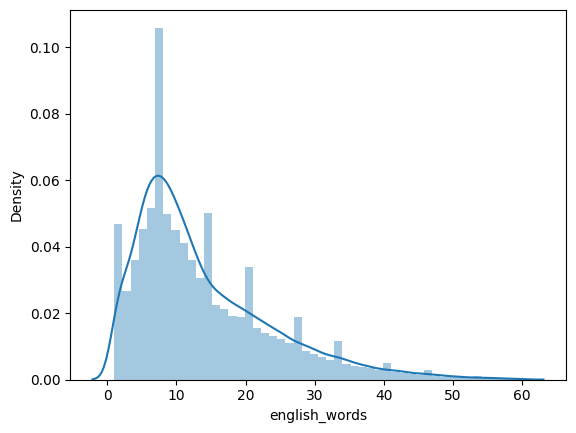

/tmp/ipykernel_36/1715726197.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['hindi_words'])
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


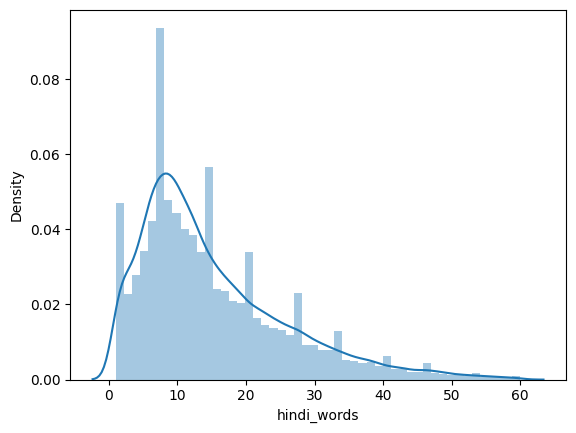

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df['english_words'])
plt.show()
sns.distplot(df['hindi_words'])
plt.show()

In [ ]:
df.drop(labels=["english_words", "hindi_words"], axis=1, inplace=True)

# Split dataset into train (85%), validation (7.5%), and test (7.5%)
train_df, temp_df = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

# Save splits for reproducibility
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

In [11]:
# Convert to Hugging Face Dataset, excluding pandas index
# train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
# val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
# test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

train_dataset = Dataset.from_pandas(pd.read_csv("/kaggle/working/train.csv"), preserve_index=False)
val_dataset = Dataset.from_pandas(pd.read_csv("/kaggle/working/val.csv"), preserve_index=False)
test_dataset = Dataset.from_pandas(pd.read_csv("/kaggle/working/test.csv"), preserve_index=False)

datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})
print("Raw dataset splits:", datasets)

Raw dataset splits: DatasetDict({
    train: Dataset({
        features: ['english_sentence', 'hindi_sentence'],
        num_rows: 68000
    })
    validation: Dataset({
        features: ['english_sentence', 'hindi_sentence'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['english_sentence', 'hindi_sentence'],
        num_rows: 6000
    })
})


In [12]:
# Define the model name to load the correct tokenizer
model_name = "Helsinki-NLP/opus-mt-en-hi"

# Load the tokenizer from the pre-trained model
try:
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    print("Tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    # Exit or handle the error appropriately if the tokenizer can't be loaded
    exit()

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Tokenizer loaded successfully.


In [13]:
# Define maximum sequence lengths for your inputs and outputs
max_input_length = 64
max_target_length = 64

# This function contains the logic to tokenize a batch of examples
def preprocess_function(examples):
    """
    Tokenizes the source (English) and target (Hindi) sentences.
    """
    # Get the source and target sentences from the batch
    inputs = examples["english_sentence"]
    targets = examples["hindi_sentence"]

    # Tokenize the source sentences. The tokenizer handles padding and truncation.
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

    # "text_target" : to tell the tokenizer the given data is actual target 
    # It ensures the target language is tokenized correctly for the decoder.
    labels = tokenizer(text_target=targets, max_length=max_target_length, truncation=True, padding="max_length")

    # The tokenized target sentences are assigned as 'labels' for the model to learn from.
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the preprocessing function to the entire dataset using .map()
# `batched=True` processes multiple rows at once for speed.
# `remove_columns` deletes the original text columns as they are no longer needed.
# Tokenize each split separately
tokenized_datasets = DatasetDict()
for split in ["train", "validation", "test"]:
    tokenized_datasets[split] = datasets[split].map(
        preprocess_function,
        batched=True,
        remove_columns=datasets[split].column_names,
        num_proc=4  # Parallelize for efficiency
    )

print("\nTokenized dataset splits:", tokenized_datasets)
print("\nExample of a tokenized sample (train):", tokenized_datasets["train"][0])

# Save tokenized splits to disk
tokenized_datasets["train"].to_json("train_tokenized.json")
tokenized_datasets["validation"].to_json("val_tokenized.json")
tokenized_datasets["test"].to_json("test_tokenized.json")

Map (num_proc=4):   0%|          | 0/68000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]


Tokenized dataset splits: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 68000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6000
    })
})

Example of a tokenized sample (train): {'input_ids': [19, 8566, 34, 39873, 10, 49695, 8, 13718, 23, 807, 17348, 44, 3, 0, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949, 61949], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Creating json from Arrow format:   0%|          | 0/68 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

5165812

In [14]:
# Load model with 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
try:
    model = MarianMTModel.from_pretrained(model_name, quantization_config=quantization_config, device_map="auto")
    print("Model loaded successfully with 4-bit quantization.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Model loaded successfully with 4-bit quantization.


In [38]:
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(61950, 512, padding_idx=61949)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(61950, 512, padding_idx=61949)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear4bit(in_features=512, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=512, out_features=512, bias=True)
            (q_proj): Linear4bit(in_features=512, out_features=512, bias=True)
            (out_proj): Linear4bit(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear4bit(in_features=512, out_features=2048, bias=True)
          (fc2): Linear4bit(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): Lay

In [15]:
# Configure QLoRA
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,  # Rank of low-rank matrices
    lora_alpha=4,  # Scaling factor for LoRA
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # Include output projection
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 589,824 || all params: 76,971,008 || trainable%: 0.7663


In [16]:
# --- Set Up Training Arguments ---
# These arguments define the hyperparameters for the training process.
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/opus-mt-en-hi-finetuned-4bit-qlora",  # Directory to save checkpoints and final model
    per_device_train_batch_size=32,  # Reduced to avoid OOM with longer sequences
    per_device_eval_batch_size=32,   # Reduced for consistency
    gradient_accumulation_steps=4,   # Effective batch size = 16 * 4 = 64
    learning_rate=1e-5,              # Slightly higher for LoRA fine-tuning
    weight_decay=0.01,
    num_train_epochs=6,             # Allow more epochs, rely on early stopping
    logging_steps=100,                # Log every 50 steps
    eval_strategy="steps",           # Evaluate every eval_steps for finer monitoring
    eval_steps=300,                  # Evaluate every 500 steps
    save_strategy="steps",           # Save every save_steps
    save_steps=300,                  # Align with eval_steps
    save_total_limit=2,              # Keep last 2 checkpoints
    predict_with_generate=True,      # Required for BLEU
    fp16=True,                       # 16-bit precision for speed
    load_best_model_at_end=True,     # Load best model by BLEU
    metric_for_best_model="bleu",
    push_to_hub=False,               # No Hub push
    gradient_checkpointing=True,     # Memory efficiency
    optim="paged_adamw_8bit",       # 8-bit optimizer
    dataloader_num_workers=4,       # Faster data loading
    lr_scheduler_type="cosine",     # Cosine scheduler for better convergence
    warmup_ratio=0.1,               # Warmup 10% of steps
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [17]:
# before initializing the trainer:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3  # Stop if the score doesn't improve for 3 steps
)

In [18]:
# Define data collator and evaluation metric
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    """Helper function to strip whitespace and format labels for sacrebleu."""
    preds = [pred.strip() for pred in preds if pred.strip()]  # Skip empty predictions
    labels = [[label.strip()] for label in labels if label.strip()]  # Skip empty labels
    return preds, labels

def compute_metrics(eval_preds):
    try:
        preds, labels = eval_preds
        if isinstance(preds, tuple):
            preds = preds[0]
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
        if not decoded_preds or not decoded_labels:
            print("Warning: Empty predictions or labels after postprocessing.")
            return {"bleu": 0.0}
        result = metric.compute(predictions=decoded_preds, references=decoded_labels)
        return {"bleu": result["score"]}
    except Exception as e:
        print(f"Error in compute_metrics: {e}")
        return {"bleu": 0.0}


In [19]:
# Initialize Trainer with EarlyStoppingCallback
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,  # Fix tokenizer deprecation
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],  # Stop after 3 non-improving evals
)

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [20]:
# Flag to resume training
resume_training = True  # Set to True to resume from last checkpoint

In [44]:
# Total Steps=ceil(Total Training Examples/(Batch Size×Gradient Accumulation Steps))×Number of Epochs
# Train or resume
try:
    # trainer.train(resume_from_checkpoint=resume_training)
    trainer.train()
except Exception as e:
    print(f"Error during training: {e}")
    exit()

Step,Training Loss,Validation Loss,Bleu
300,5.561100,5.361969,6.783580
600,4.025800,3.685468,6.847987
900,2.411600,2.184927,6.974576
1200,1.936700,1.831466,7.026545
1500,1.857400,1.773879,7.055632


In [21]:
# Total Steps=ceil(Total Training Examples/(Batch Size×Gradient Accumulation Steps))×Number of Epochs
# Train or resume
try:
    trainer.train(resume_from_checkpoint=resume_training)
    # trainer.train()
except Exception as e:
    print(f"Error during training: {e}")
    exit()

Step,Training Loss,Validation Loss,Bleu
1800,1.677500,1.605287,7.099071
2100,1.577100,1.526071,7.197022
2400,1.565500,1.497209,7.323922
2700,1.521800,1.485494,7.307513
3000,1.520000,1.481954,7.318408


In [22]:
# Step 10: Save the LoRA adapter
final_adapter_path = "/kaggle/working/final_lora_adapter"
trainer.save_model(final_adapter_path)
print(f"Final LoRA adapter and tokenizer saved to '{final_adapter_path}'")

Final LoRA adapter and tokenizer saved to '/kaggle/working/final_lora_adapter'


In [23]:
print("Starting the merge process...")

# --- Step 2: Load the base model in full precision ---
# We need to load it in float32 to be able to merge the weights
base_model = MarianMTModel.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
)

# The path where i save the full, merged model
output_dir = "/kaggle/working/opus-mt-en-hi-4-bit-quantized-finetuned-model"

# Load the PEFT model with your trained adapters
# This loads the base model and attaches the adapters to it
peft_model = PeftModel.from_pretrained(
    base_model,
    final_adapter_path,
)
print("Adapters loaded onto the quantized model.")

# Merge the adapters into the base model
# This is the key step that combines the weights
merged_model = peft_model.merge_and_unload()
print("Model and adapters merged successfully.")

# Save the complete model and tokenizer
# This saves the full model, which can be loaded without PEFT
merged_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Full, fine-tuned model saved to '{output_dir}'")

Starting the merge process...
Adapters loaded onto the quantized model.
Model and adapters merged successfully.


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Full, fine-tuned model saved to '/kaggle/working/opus-mt-en-hi-4-bit-quantized-finetuned-model'


In [25]:

# Load model for inference
final_adapter_path = "/kaggle/working/final_lora_adapter"
print("\n--- Preparing Model for Inference ---")
try:
    model_path = "/kaggle/working/opus-mt-en-hi-4-bit-quantized-finetuned-model"
    # Load the tokenizer and the model from the local path
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    inference_model = MarianMTModel.from_pretrained(model_path, device_map='auto')
    print("merged model loaded.")
except Exception as e:
    print(f"Error loading model for inference: {e}")
    exit()

# Test the merged model
inference_model.eval() # Set the model to evaluation mode
print("\n--- Testing Translation ---")
translator = pipeline(
    "translation",
    model=inference_model,
    tokenizer=tokenizer
)
text = "Hello, how are you?"
translated = translator(text)
print(f"Original: {text}")
print(f"Translated: {translated[0]['translation_text']}")

# Step 13: Evaluate on test set
print("\n--- Evaluating on Test Set ---")
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print(f"Test Set BLEU Score: {test_results['eval_bleu']:.4f}")



--- Preparing Model for Inference ---


Device set to use cuda:0


merged model loaded.

--- Testing Translation ---
Original: Hello, how are you?
Translated: हैलो, तुम कैसे हो?

--- Evaluating on Test Set ---


Test Set BLEU Score: 7.0479


In [14]:
print("\n--- Evaluating on Test Set ---")

predictions = []
references = []

for example in tokenized_datasets["test"]:
    # 1. Decode the input_ids back to a string
    # skip_special_tokens=True removes padding and other special tokens
    source_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    
    # 2. Generate the translation using the pipeline with the corrected string input
    translated_output = translator(source_text)
    
    # Extract the generated text
    predicted_text = translated_output[0]['translation_text']
    
    # 3. Decode the labels to get the reference string
    # We must filter out the -100 labels, which are used to ignore padding in loss calculation
    label_ids = [label for label in example["labels"] if label != -100]
    reference_text = tokenizer.decode(label_ids, skip_special_tokens=True)

    predictions.append(predicted_text)
    # The metric expects a list of lists for references
    references.append([reference_text])

metric = evaluate.load("sacrebleu")
# Compute the BLEU score
results = metric.compute(predictions=predictions, references=references)

print(f"Test Set BLEU Score: {results['score']:.4f}")


--- Evaluating on Test Set ---
Test Set BLEU Score: 7.0799


In [24]:
import shutil
import os
directory_to_zip = "/kaggle/working/opus-mt-en-hi-4-bit-quantized-finetuned-model"
output_zip_file = "/kaggle/working/opus-mt-en-hi-4-bit-quantized-finetuned-model"
def zip_directory(directory_path, output_path):
    """
    Compresses a directory into a zip archive.

    This function uses shutil.make_archive, which is the standard
    and recommended way to create an archive from a directory.

    Args:
        directory_path (str): The path to the directory to be zipped.
        output_path (str): The desired path and filename for the output
                           zip archive (without the .zip extension).
    """
    try:
        # The 'zip' argument specifies the archive format.
        # The base_dir argument specifies the directory to be archived.
        shutil.make_archive(output_path, 'zip', directory_path)
        print(f"Successfully created zip archive at: {output_path}.zip")
    except Exception as e:
        print(f"An error occurred: {e}")
zip_directory(directory_to_zip, output_zip_file)

Successfully created zip archive at: /kaggle/working/opus-mt-en-hi-4-bit-quantized-finetuned-model.zip


In [ ]:

# Step 14: Clean up intermediate files
print("\n--- Cleaning up intermediate files ---")
for file in ["train.csv", "val.csv", "test.csv", "train_tokenized.json", "val_tokenized.json", "test_tokenized.json"]:
    try:
        os.remove(f"/kaggle/working/{file}")
        print(f"Removed /kaggle/working/{file}.")
    except OSError as e:
        print(f"Error removing /kaggle/working/{file}: {e}")